In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 413 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


In [2]:
def feature_label_generator(raw_data, window_size=16):
    """
    description:
        输入时间序列，根据时间系列生成样本（特征和标签）
    parameters:
        raw_data: 原始时间序列
        Window_size: 滑动窗口长度
    returns:
        features: 生成的特征集合
        labels: 生成的标签集合
    """
    raw_data = np.array(raw_data) if type(raw_data) is not np.ndarray else raw_data
    # features, labels = [], []
    sample = []
    # for i in range(len(raw_data) - window_size):
    #     features.append(raw_data[i:i + window_size])
    #     labels.append(raw_data[i + window_size])
    # return features, labels
    for i in range(len(raw_data) - window_size):
        sample.append((raw_data[i:i + window_size], raw_data[i + window_size]))
    return sample

# test_raw_data = np.array(range(10))
# features, labels = feature_label_generator(test_raw_data, window_size=3)
# print(features)
# print(labels)

class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sequence = self.data[index][0].reshape(1, 16)
        target = self.data[index][1]
        return torch.FloatTensor(sequence), torch.FloatTensor([target])

In [3]:
class TSCNN(nn.Module):
    def __init__(self):
        super(TSCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2)
        # self.relu = nn.LeakyReLU(negative_slope=0.1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2)
        self.fc1 = nn.Linear(32 * 14, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        batch_size= x.size(0)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

def train(model, train_dataloader, loss_fn, optimizer, epoch):
    model.train()
    for idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device).reshape(-1, 1)
        pred = model(X)
        loss = loss_fn(y, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

using device: cuda


## CALCE数据集

In [5]:
# 读取容量数据
battery_names = []
calce_data_path = "../../data/processed_data/calce/calce_capacity.npy"
calce_data = np.load(calce_data_path, allow_pickle=True)

b35 = calce_data[0]
b36 = calce_data[1]
b37 = calce_data[2]
b38 = calce_data[3]


window_size = 16
b35 = feature_label_generator(b35)
b36 = feature_label_generator(b36)
b37 = feature_label_generator(b37)
b38 = feature_label_generator(b38)

/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


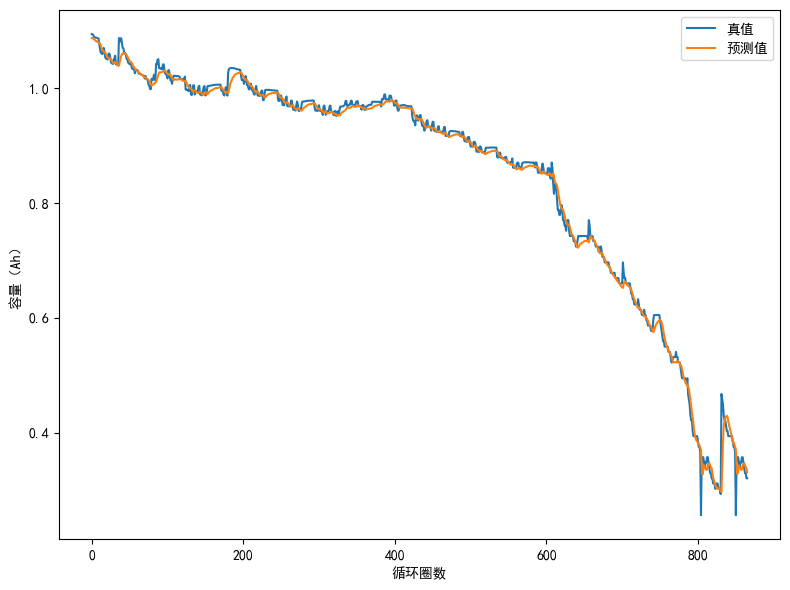

/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


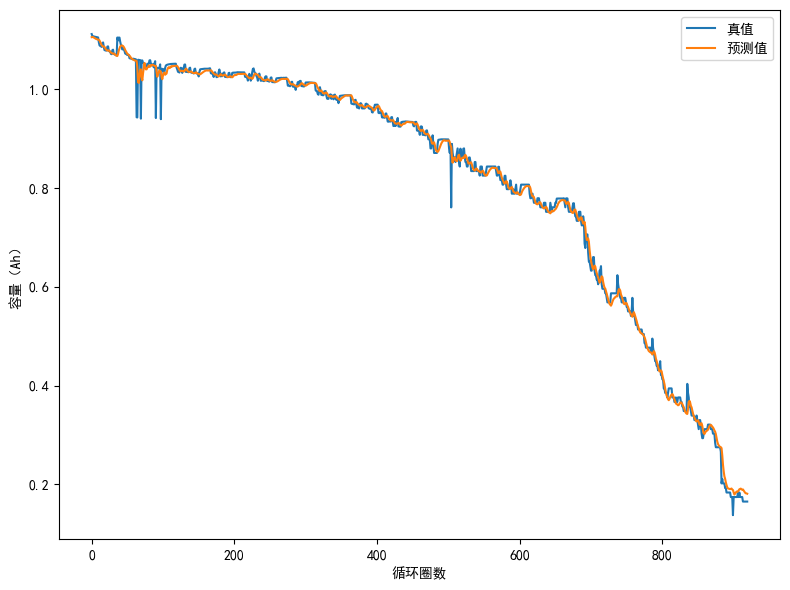

/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


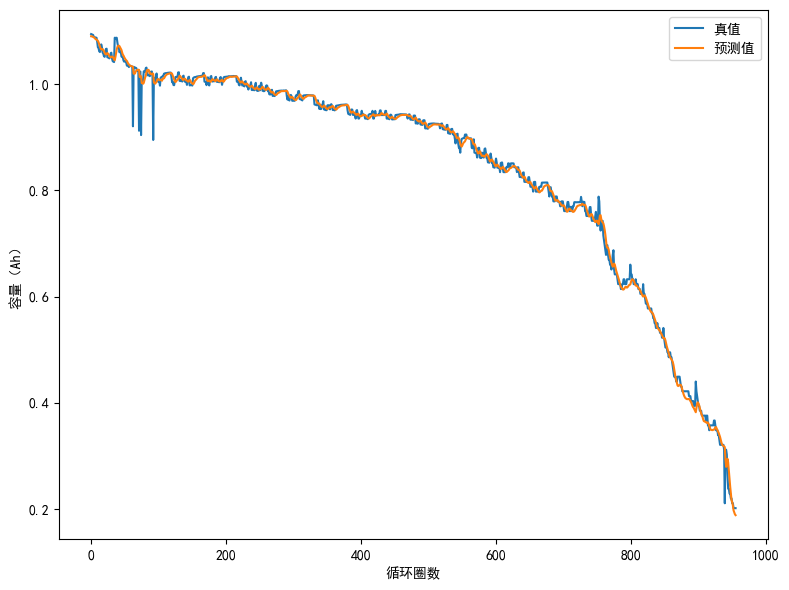

/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


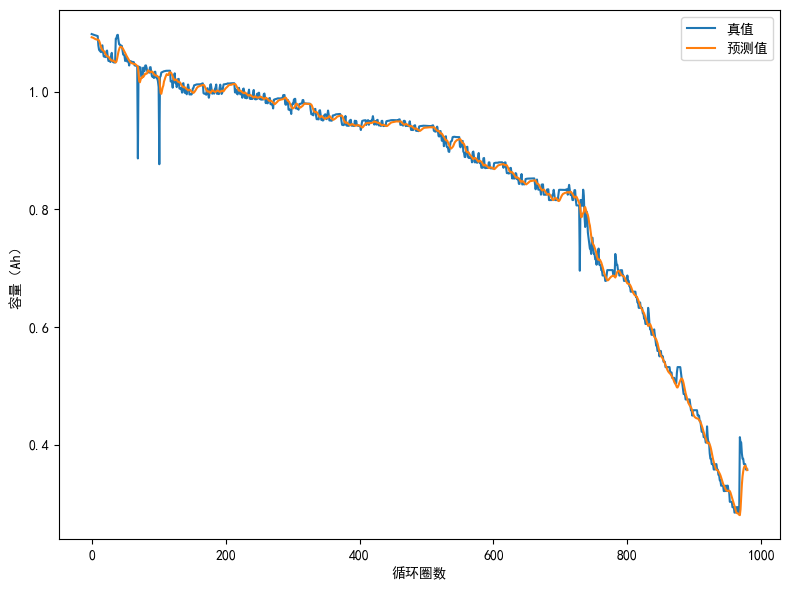

In [6]:
dataset = (b35, b36, b37, b38)
battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# fig, ax = plt.subplots(1, 4, figsize=(15, 3))

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i], dtype=object)
    test_dataset = dataset[idx]

    model = TSCNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.00001)

    train_dataset = BatteryDataset(train_dataset)
    test_dataset = BatteryDataset(test_dataset)

    batch_size = 16
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

    epochs = 500
    # print("训练开始")
    for epoch in range(epochs):
        train(model, train_dataloader, criterion, optimizer, epoch)
    # print("训练完成")

    y_pred, gt, y1, y2 = [], [], [], []
    model.eval()
    for cnt, (X, y) in enumerate(test_dataset):
        X = X.to(device)
        y_pred.append(float(model(X)))
        gt.append(y)

    # ax[idx].plot(gt)
    # ax[idx].plot(y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(gt)
    plt.plot(y_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数")
    plt.ylabel("容量（Ah）")
    save_path = f"../../assets/thesis_figures/chapter_3/calce_{battery_names[idx]}_cnn.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

## NASA数据集

In [7]:
nasa_data_path = "../../data/processed_data/nasa/nasa_capacity.npy"
nasa_data = np.load(nasa_data_path, allow_pickle=True)
b05 = nasa_data[0]
b06 = nasa_data[1]
b07 = nasa_data[2]
b18 = nasa_data[3]

b05 = feature_label_generator(b05)
b06 = feature_label_generator(b06)
b07 = feature_label_generator(b07)
b18 = feature_label_generator(b18)

/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


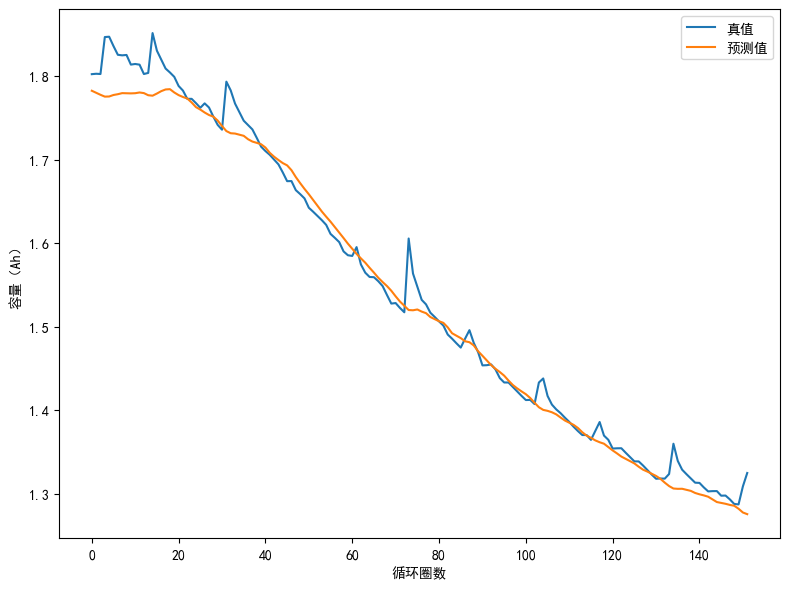

/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


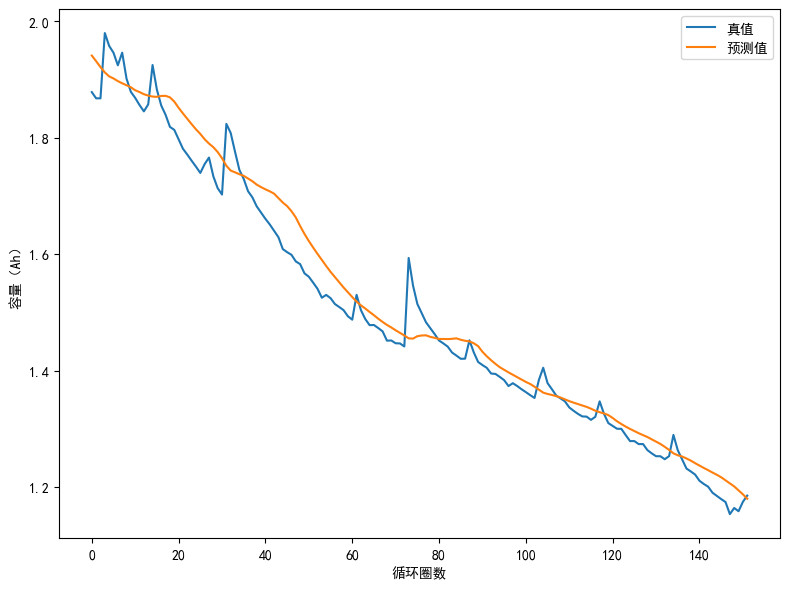

/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


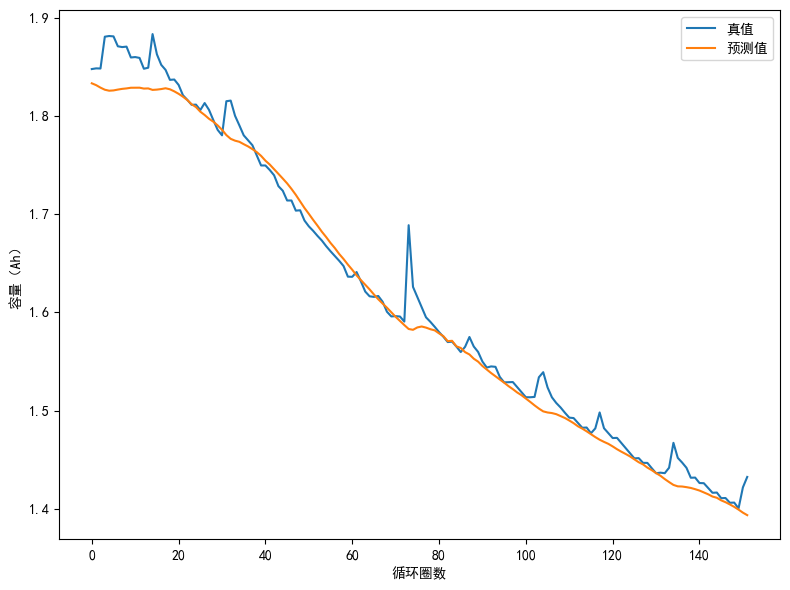

/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


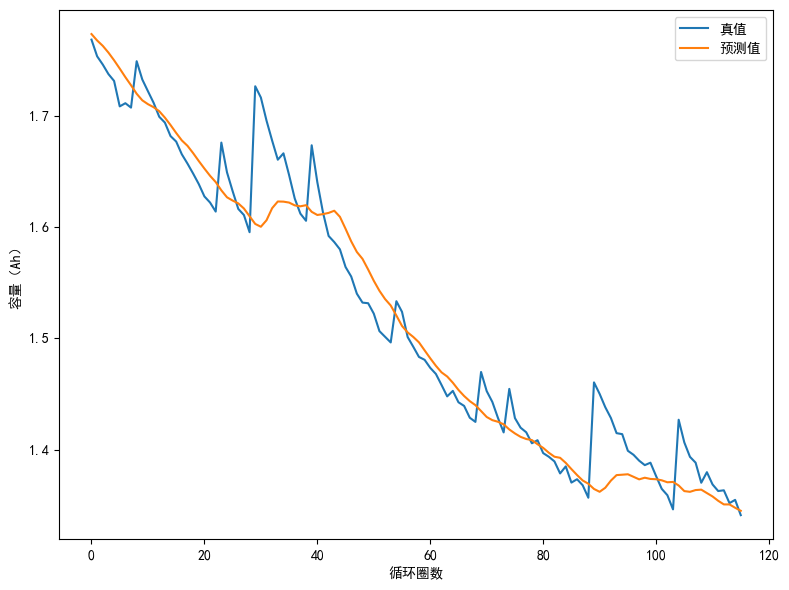

In [9]:
dataset = (b05, b06, b07, b18)
battery_names = ["B0005", "B0006", "B0007", "B0018"]

# fig, ax = plt.subplots(1, 4, figsize=(15, 3))

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i], dtype=object)
    test_dataset = dataset[idx]

    model = TSCNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.00001)

    train_dataset = BatteryDataset(train_dataset)
    test_dataset = BatteryDataset(test_dataset)

    batch_size = 16
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

    epochs = 500
    # print("训练开始")
    for epoch in range(epochs):
        train(model, train_dataloader, criterion, optimizer, epoch)
    # print("训练完成")

    y_pred, gt, y1, y2 = [], [], [], []
    model.eval()
    for cnt, (X, y) in enumerate(test_dataset):
        X = X.to(device)
        y_pred.append(float(model(X)))
        gt.append(y)

    # ax[idx].plot(gt)
    # ax[idx].plot(y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(gt)
    plt.plot(y_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数")
    plt.ylabel("容量（Ah）")
    save_path = f"../../assets/thesis_figures/chapter_3/nasa_{battery_names[idx]}_cnn.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()